## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

from scipy.io import loadmat

## Cargar datos

In [2]:
data = loadmat('ex5data1.mat')

X = data['X']
Y = data['y'].ravel()
X_val = data['Xval']
Y_val = data['yval'].ravel()
X_test = data['Xtest']
Y_test = data['ytest'].ravel()

m = X.shape[0]
X = np.hstack([np.ones([m, 1]), X])
m_val = X_val.shape[0]
X_val = np.hstack([np.ones([m_val, 1]), X_val])

## Regresión Lineal multivariable

In [3]:
def reg_lin_mul_var (theta, X, Y, lambd):
    
    m = X.shape[0]
    n = X.shape[1]
    J_theta = 0
    gradient = []

    H = np.dot(X, theta)
    diff = (H - Y)
    
    # Coste
    J_theta = (1 / (2 * m)) * np.sum(np.square(diff))
    
    # Coste Regularizado
    reg = lambd / (2 * m) * np.sum(np.square(theta[1:]))
    J_theta += reg

    # Gradiente
    gradient = (1 / m) * np.sum(diff * X.T, axis=1)
    
    # Gradiente Regularizada
    reg = (lambd/m) * theta[1:]
    gradient[1:] += reg


    return (J_theta, gradient)

In [4]:
# PRUEBAS
theta = np.array([1, 1])
lambd = 1
cost, gradient = reg_lin_mul_var(theta, X, Y, lambd)
print("El coste es:\t\t{}\nLa gradiante es:\t{}".format(cost, gradient))

El coste es:		303.9931922202643
La gradiante es:	[-15.30301567 598.25074417]


## Minimize

In [5]:
res = opt.minimize(
    fun = reg_lin_mul_var,
    x0 = theta,
    args=(X, Y, 0),
    method='TNC',
    jac=True
)

theta_opt = res.x

## Dibujar recta de resultados

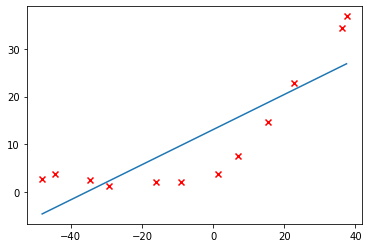

In [6]:
plt.figure()
plt.scatter(X[:, 1:], Y, marker='x', c='red')

X_min, X_max = np.min(X, axis=0), np.max(X, axis=0)
Y_min = np.sum(theta_opt * X_min)
Y_max = np.sum(theta_opt * X_max)
X_min = X_min[1:]
X_max = X_max[1:]

plt.plot([X_min, X_max], [Y_min, Y_max])

plt.show()

## Dibujar curva de aprendizaje

In [7]:
def learningErrors(theta, X, Y, X_val, Y_val, lambd = 0):
    """
    Returns the Train error vector and the Cross Validation error vector
    """
    
    trainError = []
    cvError = []
    m = X.shape[0]
    
    for i in range(1, m + 1):

        X_i = X[0:i]
        Y_i = Y[0:i]

        res = opt.minimize(
            fun = reg_lin_mul_var,
            x0 = theta,
            args=(X_i, Y_i, lambd),
            method='TNC',
            jac=True
        )

        trainError.append(reg_lin_mul_var(res.x, X_i, Y_i, lambd)[0])
        cvError.append(reg_lin_mul_var(res.x, X_val, Y_val, lambd)[0])
        
    return np.array(trainError), np.array(cvError)

In [8]:
def printLearningErrors(trainError, cvError):
    """
    Prints the Train error and the Cross Validation
    Doesnt return anything
    """
    
    plt.figure()
    
    r = range(0, len(trainError))

    plt.plot(r, trainError)
    plt.plot(r, cvError)
    plt.legend(['Train', 'Cross Validation'])

    plt.show()

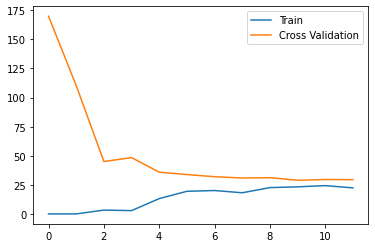

In [9]:
trainError, cvError = learningErrors(theta, X, Y, X_val, Y_val)
printLearningErrors(trainError, cvError)

# Regresion Polinomial

## Cargar datos

In [10]:
data = loadmat('ex5data1.mat')

X = data['X']
Y = data['y'].ravel()
X_val = data['Xval']
Y_val = data['yval'].ravel()
X_test = data['Xtest']
Y_test = data['ytest'].ravel()

m = X.shape[0]
m_val = X_val.shape[0]

## Polynomial data

In [11]:
def poly_data(X, p=1):
    """
    INPUT: Matix (m, 1) && p
    OUTPUT: Matrix (m, p)
    """
    res = np.zeros((X.shape[0], p))
        
    for i in range(0, p):
        res[:, i] = X ** (i + 1)
    
    return res

## Normalize

In [12]:
def normalize(X):
    m = X.shape[0]
    mu = np.array([np.mean(X, axis = 0)])
    sigma = np.array([np.std(X, axis = 0)])
    X_norm = np.divide(np.subtract(X, mu), sigma)
    
    X_norm = np.hstack([np.ones([m, 1]), X_norm])

    return X_norm, mu, sigma

In [13]:
def normalize_with_values(X, mu, sigma):
    m = X.shape[0]

    X_norm = np.divide(np.subtract(X, mu), sigma)    
    X_norm = np.hstack([np.ones([m, 1]), X_norm])

    return X_norm

## Minimize

In [14]:
p = 8
theta = np.zeros(p + 1)
lambd = 0

X_poly = poly_data(X.ravel(), p)
X_poly_norm, mu, sigma = normalize(X_poly)

res = opt.minimize(
    fun = reg_lin_mul_var,
    x0 = theta,
    args=(X_poly_norm, Y, lambd),
    method='TNC',
    jac=True
)

theta_opt = res.x

## Dibujar recta de resultados

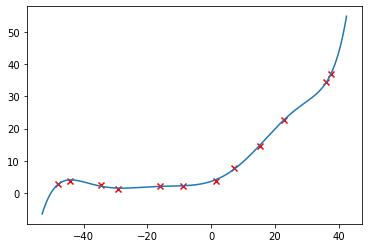

In [15]:
# Range of values -> -5 and +5 to show beyond the actual data
ranX = np.arange(
    np.min(X) - 5,
    np.max(X) + 5,
    .05
)

# Need to normalize with mu and sigma
ranX_poly_norm = normalize_with_values(poly_data(ranX, p), mu, sigma)

# Predict values
Y_hat = np.dot(ranX_poly_norm, theta_opt)

# Plot the figure
plt.figure()
plt.scatter(X, Y, marker='x', c='red')
plt.plot(ranX, Y_hat)
plt.show()

## Dibujar la curva de aprendizaje

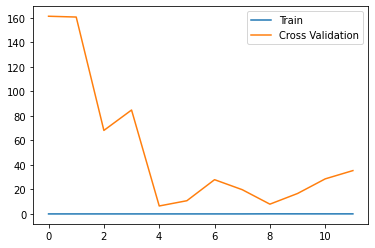

In [16]:
X_poly_norm, mu, sigma = normalize(poly_data(X.ravel(), p))

# Need to normalize with mu and sigma
X_val_poly_norm = normalize_with_values(
    poly_data(X_val.ravel(), p),
    mu,
    sigma
)

trainError, cvError = learningErrors(theta,
                                     X_poly_norm,
                                     Y,
                                     X_val_poly_norm,
                                     Y_val,
                                     0
                                    )

printLearningErrors(trainError, cvError)

## Parámetro lambda

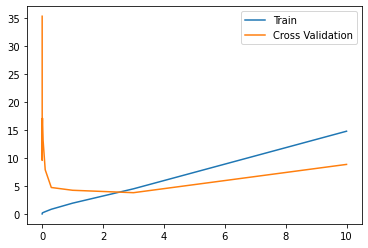

In [17]:
lambdas = [ 0, .001, .003, .01, .03, .1, .3, 1, 3, 10 ]
p = 8
trainError_vector = []
cvError_vector = []

plt.figure()

X_poly_norm, mu, sigma = normalize(poly_data(X.ravel(), p))

X_val_poly_norm = normalize_with_values(
    poly_data(X_val.ravel(), p),
    mu,
    sigma
)


for lambd in lambdas:
    theta = np.zeros(p + 1)
    
    res = opt.minimize(
        fun = reg_lin_mul_var,
        x0 = theta,
        args=(X_poly_norm, Y, lambd),
        method='TNC',
        jac=True,
    )
    
    theta_opt = res.x
        
    trainError_vector.append(reg_lin_mul_var(theta_opt, X_poly_norm, Y, 0)[0])
    cvError_vector.append(reg_lin_mul_var(theta_opt, X_val_poly_norm, Y_val, 0)[0])
    
plt.plot(lambdas, trainError_vector, label="Train")
plt.plot(lambdas, cvError_vector, label="Cross Validation")
plt.legend()
plt.show()

In [18]:
lambd_opt = 3
p = 8
theta = np.zeros(p + 1)

X_poly_norm, mu, sigma = normalize(poly_data(X.ravel(), p))

res = opt.minimize(
    fun = reg_lin_mul_var,
    x0 = theta,
    args=(X_poly_norm, Y, lambd_opt),
    method='TNC',
    jac=True,
)

X_test_poly_norm = normalize_with_values(
    poly_data(X_test.ravel(), p),
    mu,
    sigma
)

reg_lin_mul_var(res.x, X_test_poly_norm, Y_test, 0)[0]

3.572044856986457